## <font color=darkblue> Introduction to Transformer Networks and attention-based models</font>


## <font color=darkred> Bibliography & additional ressources </font>

- [1]"Attention is all you need", Vaswani, A. et al., NeurIPS 2017, https://proceedings.neurips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf
``Seminal paper on attention mechanism``.
- [2] "Layer normalization ", Lei Bai, J. and al., 2016, https://ui.adsabs.harvard.edu/abs/2016arXiv160706450L/abstract
- [3] http://jalammar.github.io/illustrated-transformer/,
``blog with high level explanations and very nice illustrations (used here)``.
- [4] "BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding", Devlin, J. and al., 2018, https://arxiv.org/abs/1810.04805

## <font color=darkred> Part *I* : Introduction </font>

- Recurrent models generate a sequence of hidden
states $h_t$, as a function of the previous hidden state $h_{t−1}$ and the input at time $t$.
- The sequential computation precludes parallelization within training examples.
- **Transformer** networks rely entirely on an **attention mechanism** to draw global dependencies between input and output **without using any sequential computation**.


### Building blocks

**Self-Attention**

Given an input sequence $X\in\mathbb{R}^{n\times d_x}$ ($n$ is the number of input features and $d_x$ is their dimension), produce 3 parametrized projections called Query $Q\in\mathbb{R}^{n\times d_k}$, Key $K\in\mathbb{R}^{n\times d_k}$, and Value $V\in\mathbb{R}^{n\times d_v}$.

They are obtained by a linear transformation of the input:

\begin{align*}
Q &= XW^{Q}\,,\\
K &= XW^{K}\,,\\
V &= XW^{V}\,,
\end{align*}

where $W^{Q}\in\mathbb{R}^{d_x\times d_k}$, $W^{K}\in\mathbb{R}^{d_x\times d_k}$ and $W^{K}\in\mathbb{R}^{d_x\times d_v}$ are learnt weight matrices.

Each input vector $X_i$ (line of $X$) is associated with $Q_i$, $K_i$, $V_i$ (lines of $Q$, $K$, $V$).

In practice, the choice, $d_k = d_v$ is standard.


![](http://jalammar.github.io/images/t/transformer_self_attention_vectors.png)

Consider an input matrix consisting of $n=3$ vectors of dimension $d_x=5$.

In [4]:
import torch
dx = 5
X = torch.normal(0, 1, size=(1, 3, dx))
# size = (Batch_size, sequence_length, input_dimension)
X.size()

torch.Size([1, 3, 5])

We build keys, queries and values with dimension $d_k=d_v=4$.

In [5]:
from torch import nn

dim = 4

query_layer = nn.Linear(dx, dim)
key_layer = nn.Linear(dx, dim)
value_layer = nn.Linear(dx, dim)

query = query_layer(X)
key = key_layer(X)
value = value_layer(X)

query.size(), key.size(), value.size()

(torch.Size([1, 3, 4]), torch.Size([1, 3, 4]), torch.Size([1, 3, 4]))

In [ ]:
#### To complete
#### Compute keys, queies and values for another input vector X with different dimensions.


The **self-attention** is then obtained by computing **dot products between each query and all keys**.

For the input vector $X_i$, we first compute $Q_i^\top K_j / \sqrt d$ for all $1\leq j \leq n$ and then the weights:


$$
\omega_i = (\omega_i(1),\ldots,\omega_i(n)) = \mathrm{softmax}(Q_i^\top K_1/\sqrt{d},\ldots,Q_i^\top K_n/\sqrt{d})\,.
$$


The vector $\omega$ contains the self-attention scores associated with $X_i$.

 **It is a vector with entries between 0 and 1 which sum to 1**.

The self-attention layer outputs for each $X_i$ the sum of values $V_j$ weighted by the attention scores:
$$
z_i =  \sum_{j=1}^n \omega_i(j) V_j\,.
$$

**Each input vector $X_i$ is then associated with its self-attention vector $z_i$**.

In the illustration below, **$d_k =64$** (the illustration does not display all components of the vectors).
![](http://jalammar.github.io/images/t/self-attention_softmax.png)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [6]:
import math

attention_scores = torch.matmul(query, key.transpose(-1, -2))
attention_scores = attention_scores / math.sqrt(dim)

attention_probs = nn.Softmax(dim=-1)(attention_scores)
attention_probs

tensor([[[0.3528, 0.3424, 0.3048],
         [0.3216, 0.3542, 0.3242],
         [0.3282, 0.3390, 0.3328]]], grad_fn=<SoftmaxBackward0>)

The attention probabilities is a tensor of shape `(batch_size, n, n)` where `n` is the length of the input (here 3).

For each element, with what strength is it "attending" to the others.

Finally we multiply the Value vectors of each element with these probabilites to get the final self-attention vectors.

In [7]:
torch.matmul(attention_probs, value)

tensor([[[-0.0583, -0.3704, -0.6103,  0.1242],
         [-0.0950, -0.3846, -0.6178,  0.0821],
         [-0.0978, -0.3891, -0.6198,  0.0772]]], grad_fn=<UnsafeViewBackward0>)

![](http://jalammar.github.io/images/t/self-attention-output.png)

In [ ]:
#### To complete
#### Compute the self-attention vectors for your input vector X.


Usually the **self-attention vectors are used as inputs of another neural network** (for instance a feed forward neural network) in order for instance to predict the output

![](http://jalammar.github.io/images/t/encoder_with_tensors.png)

The following code (inspired by **BERT**) is a simple pytorch implementation of a single layer transformer, with a single head. A few implementation details have been omitted for clarity. In this transformer, for the sake of clarity , we suppose that all the dimensions $d_x$, $d_k$, $d_v$ are equal (```self.dim``` in the code).

In [8]:
class SimpleTransformer(nn.Module):
    def __init__(self, hidden_dim = 32):
        super().__init__()
        self.dim = hidden_dim
        self.query_layer = nn.Linear(self.dim, self.dim)
        self.key_layer = nn.Linear(self.dim, self.dim)
        self.value_layer = nn.Linear(self.dim, self.dim)
        self.output_layer = nn.Linear(self.dim, self.dim)
        self.dropout = nn.Dropout(0.2)
        self.LayerNorm = nn.LayerNorm(self.dim, eps=1e-4)

    def self_attention(self, X):
        query = self.query_layer(X)
        key = self.key_layer(X)
        value = self.value_layer(X)

        # Take the dot product between "query" and "key" to get the raw attention scores.
        #attention_scores = 
        #attention_scores = 
        #attention_probs = 

        return torch.matmul(attention_probs, value)


    def forward(self, X):
        Z = self.self_attention(X)
        Z = self.output_layer(Z)
        Z = self.dropout(Z)
        Z = self.LayerNorm(Z + X) 
        return Z

- The trainable parameters are in the 4 layers: **key**, **value**, **query** and **output layer**.
- There is a **skip connection**: we add the input to the output. This is similar to residual learning in the [Resnet paper](https://arxiv.org/abs/1512.03385).
- A **normalization scheme** is applied at the end of each layer:
$$
y = \frac{X−\mathbb{E}[X]}{ \mathbb{V}[X]+\varepsilon}\gamma+\beta\,,
$$
where $\gamma$ and $\beta$ are new trainable parameters. It enables to stabilize the activation level for optimization purposes (better flow of gradients during SGD). Read the original [paper](https://arxiv.org/abs/1607.06450) for more details.


In [10]:
T = SimpleTransformer(hidden_dim=5)
T(X)

tensor([[[-0.8012,  0.2220, -0.7888, -0.4887,  1.8567],
         [-0.0019,  0.6270, -1.4636, -0.6078,  1.4462],
         [ 0.3965, -0.6439,  1.7731, -0.5184, -1.0073]]],
       grad_fn=<NativeLayerNormBackward0>)

### Multi-head attention

The self-attention layer is usually combined with **multi-headed** attention.

- Each **head** $h$ has its weights $W^Q_h$, $W^V_h$, $W^K_h$ which allows to build different self-attention vectors.

- Each heads leads to different projections (embeddings) of the input data, that can be used to learn several features of the data.

- It allows the model to represent the data in different subspaces, and to better capture the complex relationships that can exist in the input data (for instance the relationships between the words in a given sentence).

In standard transformers, there are multiple layers as such, and each layer has $H$ *attention heads*, which corresponds to $H$ heads $Q^h,K^h,V^h$, $1\leq h \leq H$ transformation matrices, and the outputs are concatenated before the last feed forward (output) layer.

Let us break down the different parts of the network to better understand its different components and the dimensions of the arrays. Define the following notations.
- $B$ is the batch size of our sample
- $S$ is the size of the input (and output) sequence  
- $H$ is the number of heads (```8``` in our example)
- $D$ is the dimension of the query-key-value space ($D = d_{k} = d_{v}$ with the previous notations). For the sake of clarity, we also suppose that $D$ is also the dimension of the input space ($D = d_{x}$)

We can now initiate our ```MultiHeadAttention``` class. It is a Pytorch neural network, so the class has to inherit from the ```nn.Module``` class. The ```__init__``` method of this module instantiates the parameters that have to be learnt in the network.

In [ ]:
class MultiHeadAttention(nn.Module):
    '''Multi-head self-attention module'''
    def __init__(self, D, H):
        super(MultiHeadAttention, self).__init__()
        self.H = H # number of heads
        self.D = D # dimension

        self.wq = nn.Linear(D, D*H)
        self.wk = nn.Linear(D, D*H)
        self.wv = nn.Linear(D, D*H)

        self.dense = nn.Linear(D*H, D)

**Matrices ```self.wq```, ```self.wk``` and ```self.wv```**

Contrarily to the self-attention with one-head, these matrices will correspond to a linear transformation from the query-key-value space of dimension $D$ into $H$ copies of itself. Hence an output dimension of $D \times H$. When we look at the connections from the input space to the first $D$ connections of the output, that is where we get the above mentioned $W^Q_1$, $W^K_1$, $W^V_1$ matrices. If we look at the connections from the input space to the following ```D``` connections, we will get $W^Q_2$, $W^K_2$, $W^V_2$. And so on.

The last network ```self.dense``` corresponds to the output network. Its input lives in a space of dimension $D \times H$ : this is because the input of the ```self.dense``` neural network will be the concatenation of the $H$ predictions in the $H$ different copies of the value space respectively made by the $H$ different heads.


We now need to delve into how precisely we build the network with these parameters.

We will basically feed the input $x$ (embedding of a word for instance) into ```self.wq```, ```self.wk``` and ```self.wv``` and process the outputs of these networks in a way that follows a multi-head attention logic before feeding them back into ```self.dense```

To better capture the structure of the network, we can follow the steps displayed in this figure.

![](http://jalammar.github.io/images/t/transformer_multi-headed_self-attention-recap.png)

#### Step 1 (image): We start from the input sentence

#### Step 2 (image): We build an embedding for each word

#### Step 3 (image above): splitting the heads

First,  we need to calculate the attention heads. To do this, we feed the input to ```self.wq```, ```self.wk``` and ```self.wv```, from which we will extract the ```D``` attention heads. These $D$ attention heads will have their own query, key and values matrices $Q_i$, $K_i$ and $V_i$. This step can be summed up in the following image.

![texte du lien](http://jalammar.github.io/images/t/transformer_attention_heads_qkv.png)

To perforfm this step, we use a function ```split_head``` that simply reshapes the output by adding a last new dimension. the $i$th component of that last dimension will be a matrix of size $(B,S,H)$ which will correspond to the matrices $Q_i$ for the $i$-th head (or $K_i$ or $V_i$ depending on the network on which we perform the operation). We will denote $Q$, $K$ and $V$ the four-dimensional matrices of size $(B,S,H,D)$  output by the ```split_head```function.

In the above image, this operation corresponds to step $3$

In [ ]:
####This is a method of the MultiHeadAttention(nn.Module) class above
def split_heads(self, x):
  B, S, D_H = x.shape
  x = x.reshape(B, S, self.H, self.D)    # (B, S, H, D)
  x = x.permute((0, 2, 1, 3))  # (B, H, S, D)
  return x

Let us start writing the ```forward``` method of our model (required if your class inherits from ```nn.Module```). It takes an input $x$ and yields the output and attention weights of the network. Let us describe the first steps of the calculation:

In [ ]:
####This is a method of the MultiHeadAttention(nn.Module) class above

def forward(self, x, mask):
    ###Step 3 (image): calculating q, k and v by splitting the heads
    q = self.wq(x)  # (B, S, D*H)
    k = self.wk(x)  # (B, S, D*H)
    v = self.wv(x)  # (B, S, D*H)

    q = self.split_heads(q)  # (B, H, S, D)
    k = self.split_heads(k)  # (B, H, S, D)
    v = self.split_heads(v)  # (B, H, S, D)

    ############################################
    ####The rest of the function is coming!!!###
    ############################################

#### Step 4 (image above): calculating the attention weights and the scaled output.

Now that we have calculated the matrices $Q$, $K$ and $V$, we can calculate the attention scores with $Q$ and $K$, and then scale the matrix $V$ with these attention weights. That is what the following ```calculate_scaled_attention``` function does. By adding a fourth dimension to these 3 matrices, we can perform this calculation for the $H$ heads all at once in a few lines.

In [ ]:
####This is a method of the MultiHeadAttention(nn.Module) class above

def calculate_scaled_attention(self, q, k, v):
    attention_scores = torch.matmul(q, k.transpose(-1, -2)) #(B,H,S,S)
    attention_scores = attention_scores / math.sqrt(self.D)

    # add the mask to the scaled tensor.
    if mask is not None:
        attention_scores += (mask * -1e9)

    attention_weights = nn.Softmax(dim=-1)(attention_scores)
    scaled_attention = torch.matmul(attention_weights, v)  # (B, H, S, D)
    return scaled_attention

Now we can add one line in our forward function that calculates the scaled attention from $Q$, $K$ and $V$

In [ ]:
####This is a method of the MultiHeadAttention(nn.Module) class above

def forward(self, x, mask):
    q = self.wq(x)  # (B, S, D*H)
    k = self.wk(x)  # (B, S, D*H)
    v = self.wv(x)  # (B, S, D*H)

    q = self.split_heads(q)  # (B, H, S, D)
    k = self.split_heads(k)  # (B, H, S, D)
    v = self.split_heads(v)  # (B, H, S, D)

    ###Step 4 (image): Computing the scaled attention from q, k and v
    scaled_attention = self.calculate_scaled_attention(q, k, v) # (B, H, S, D)

    ############################################
    ####The rest of the function is coming!!!###
    ############################################

#### Step 5 (image above): Concatenating the outputs of the attention layer and feeding the result to the output layer.

Now that we have calculated the attention weights and scaled the matrix $V$ with these attention weights, we have an actual output of dimension $(B, H, S, D)$. But now we need to reduce the dimension of this output by one and rearrange its components to feed our ```self.dense``` layer, with an input of size $(B, S, D\times H)$. As we are building a self-attention model, the dimension of this Dense layer must the same as the input: $D$. The following image sums up this concatenating process.

![](http://jalammar.github.io/images/t/transformer_attention_heads_weight_matrix_o.png)

In [ ]:
####This is a method of the MultiHeadAttention(nn.Module) class above

def concat_heads(self, x):
    '''(B, H, S, D) => (B, S, D*H)'''
    B, H, S, D = x.shape
    x = x.permute((0, 2, 1, 3)).contiguous()  # (B, S, H, D)
    x = x.reshape((B, S, H*D))   # (B, S, D*H)
    return x

Now we can finish writing (at last!) the ```forward``` function.

In [ ]:
####This is a method of the MultiHeadAttention(nn.Module) class above

def forward(self, x, mask):
    q = self.wq(x)  # (B, S, D*H)
    k = self.wk(x)  # (B, S, D*H)
    v = self.wv(x)  # (B, S, D*H)

    q = self.split_heads(q)  # (B, H, S, D)
    k = self.split_heads(k)  # (B, H, S, D)
    v = self.split_heads(v)  # (B, H, S, D)

    scaled_attention = self.calculate_scaled_attention(q, k, v)

    ####Step 5 (image): concatenating the outputs and feeding the dense networks
    concat_attention = self.concat_heads(scaled_attention) # (B, S, D*H)
    output = self.dense(concat_attention)  # (B, S, D)

    return output, attention_weights

#### Summary

Altogether, here is the whole class ```MultiHeadAttention```

In [ ]:
import torch.nn as nn
import math

class MultiHeadAttention(nn.Module):
    '''Multi-head self-attention module'''
    def __init__(self, D, H):
        super(MultiHeadAttention, self).__init__()
        self.H = H # number of heads
        self.D = D # dimension

        self.wq = nn.Linear(D, D*H)
        self.wk = nn.Linear(D, D*H)
        self.wv = nn.Linear(D, D*H)

        self.dense = nn.Linear(D*H, D)

    def split_heads(self, x):
        '''(B, S, D*H) => (B, H, S, D)'''
        B, S, D_H = x.shape
        x = x.reshape(B, S, self.H, self.D)    # (B, S, H, D)
        x = x.permute((0, 2, 1, 3))  # (B, H, S, D)
        return x

    def concat_heads(self, x):
        '''(B, H, S, D) => (B, S, D*H)'''
        B, H, S, D = x.shape
        x = x.permute((0, 2, 1, 3)).contiguous()  # (B, S, H, D)
        x = x.reshape((B, S, H*D))   # (B, S, D*H)
        return x

    def calculate_scaled_attention(self, q, k, v):
        attention_scores = torch.matmul(q, k.transpose(-1, -2)) #(B,H,S,S)
        attention_scores = attention_scores / math.sqrt(self.D)

        # add the mask to the scaled tensor.
        if mask is not None:
            attention_scores += (mask * -1e9)

        attention_weights = nn.Softmax(dim=-1)(attention_scores)
        scaled_attention = torch.matmul(attention_weights, v)  # (B, H, S, D)
        return scaled_attention


    def forward(self, x, mask):
        q = self.wq(x)  # (B, S, D*H)
        k = self.wk(x)  # (B, S, D*H)
        v = self.wv(x)  # (B, S, D*H)

        q = self.split_heads(q)  # (B, H, S, D)
        k = self.split_heads(k)  # (B, H, S, D)
        v = self.split_heads(v)  # (B, H, S, D)

        scaled_attention = self.calculate_scaled_attention(q, k, v)


        concat_attention = self.concat_heads(scaled_attention) # (B, S, D*H)
        output = self.dense(concat_attention)  # (B, S, D)

        return output, attention_weights

You can see below an illustration of a full Transformer architecture (**the encoder-decoder formalism will be detailed in the next session**).
The important practical step to remember is that outputs of one layer are concatenated before being used as an input for the following layer.


![](https://www.researchgate.net/publication/344197785/figure/fig2/AS:934416989843456@1599793779015/Transformer-model-architecture-described-in-Attention-Is-All-You-Need-6.ppm)

### Links between LSTM and attention models

Following https://arxiv.org/pdf/1805.03716.pdf, we can consider a simplifier LSTM network. The prediction of a new data is performed by updating $(c_t,h_t)_{t\geq 0}$, using $\sigma$ as a generic activation function:
\begin{align*}
\tilde c_t &= \sigma (W_1 h_{t-1} + W_2 X_{t})\,,\\
i_t &= \sigma (W_3 h_{t-1} + W_4 X_{t})\,,\\
f_t &= \sigma (W_5 h_{t-1} + W_6 X_{t})\,,\\
c_t &= i_t \tilde c_t + f_t c_{t-1}\,,\\
o_t &= \sigma (W_7 h_{t-1} + W_8 X_{t})\,,\\
h_t &= o_t\sigma(c_t)\,,\\
\end{align*}

In this setting we can derive a recursive formulation of $c_t$:
$$
c_t = \sum_{j=0}^t i_j \left(\prod_{k=j+1}^t f_k\right)\tilde c_j\,.
$$
The expression is obtained by induction. If this is true at time $t$, write at $t+1$,
\begin{align*}
c_{t+1} = i_{t+1} \tilde c_{t+1} + f_{t+1} c_{t} &= i_{t+1} \tilde c_{t+1} + f_{t+1} \sum_{j=0}^t i_j \left(\prod_{k=j+1}^t f_k\right)\tilde c_j\,,\\
&= \sum_{j=0}^{t+1} i_j \left(\prod_{k=j+1}^{t+1} f_k\right)\tilde c_j\,.
\end{align*}


We note that $c_{t+1}$ can be written
$$
c_{t+1} = \sum_{j=0}^{t+1}\omega_j^{t+1}\tilde c_j\,.
$$

In an **oversimplified model** model where
\begin{align*}
\tilde c_t &= \sigma (W_2 X_{t})\,,\\
i_t &= \sigma (W_4 X_{t})\,,\\
f_t &= \sigma (W_6 X_{t})\,,
\end{align*}
we obtain
$$
c_t = \sum_{j=0}^t \sigma (W_2 X_{j})\left(\prod_{k=j+1}^t \sigma (W_6 X_{k})\right)\sigma (W_2 X_{j})\,.
$$
It is therefore an **element-wise weighted sum of featurized inputs**.

Contrary to attention models (and to Transformers) the weights are constrained and the fact that $\|f_k\|\leq 1$ leads to **exponentially decaying weights**.

### Discussion and additional remarks

**Positional encoding and masking**

The nice feature of self-attention with respect to recurrent models is that **every input vector can have a large attention score no matter its position** in the past with respect to the current input (for time series, sequences of words, etc.).

**Positional encoding** assigns a representation to each input vector to **determine its location**. We usually **avoid to use only an index number** which can be numerically unstable for very long sequences.

The most widespread solution to add an positional information is to **create an embedding to map the position index to a vector**.

![](https://machinelearningmastery.com/wp-content/uploads/2022/01/PE1-1536x818.png)

In the original paper, the positional encoding of the $i$-th input vector is:
$$
P_i = \left(\cos(\omega_1i),\sin(\omega_1i),\ldots,\sin(\omega_{d/2}i),\cos(\omega_{d/2}i)\right)^\top\,,
$$
where
$$
\omega_j = c^{-2j/d}\,,
$$
with $c>1$.

The traditional use of the positional encoding is to work in an extended state space where **we concatenate the positional encoding with each keys, queries, values**.

### Pretrained Transformers

Most of the time for natural language processing applications, we use a well-designed existing architecture instead of coding one. Besides the neural network architecture, we also use the pre-trained weights as they transfer well to downstream tasks. Here, the popular [Transformers library](https://huggingface.co/models) from HuggingFace is used.

In [ ]:
!pip install transformers
!pip install bertviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 59.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.1/143.1 kB 15.2 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.4
    Uninstalling urllib3-2.0.4:
      Successfully uninstalled urllib3-2.0.4


In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

In [ ]:
# A GPT2 Language model is loaded
model = GPT2LMHeadModel.from_pretrained('gpt2', output_attentions=True)
# The corresponding tokenizer (splitting a text string into tokens in the GPT-2 vocabulary)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

In [ ]:
nb_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
print(f"number of trainable parameters in GPT-2 language model: {nb_params:,}")

number of trainable parameters in GPT-2 language model: 124,439,808


In [ ]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [ ]:
text = "Building artificial intelligence tools requires a solid mathematical"
inputs = tokenizer.encode_plus(text, return_tensors='pt', add_special_tokens=True)
input_ids = inputs['input_ids']
input_ids

tensor([[25954, 11666,  4430,  4899,  4433,   257,  4735, 18069]])

In [ ]:
outputs = model(input_ids)

In [ ]:
inputs = tokenizer.encode(text, return_tensors='pt', add_special_tokens=True)
outputs = model(inputs, return_dict=True)

In [ ]:
logits = outputs.logits[0,-1].detach().cpu()
probas = torch.nn.functional.softmax(logits, dim=-1)
token_ids = logits.argsort()[-5:]

In [ ]:
print(text)
[tokenizer.decode(id)+f": ({probas[id]:.2f})" for id in token_ids][::-1]

Building artificial intelligence tools requires a solid mathematical


[' foundation: (0.62)',
 ' understanding: (0.16)',
 ' model: (0.05)',
 ' framework: (0.04)',
 ' approach: (0.01)']

Visualisation of attention weights in different attention heads, for different layers. Note that there are 12 layers,12 heads, and 8 tokens, so there are a lot of different attentions to visualize here !

In [ ]:
attention = model(input_ids)[-1]
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)

In [ ]:
from IPython.core.display import HTML
display(HTML('<script src="/static/components/requirejs/require.js"></script>'))
# Above two lines only needed when running in Colab

from bertviz import head_view
head_view(attention, tokens)

<IPython.core.display.Javascript object>

## <font color=darkred> Part II: Introduction to Transformers for time series</font>

In [ ]:
!pip install --quiet tsloader git+https://github.com/maxjcohen/transformer
!curl -O https://gitlab.com/max.cohen/ateliers-algos/-/raw/main/heating_lilles.csv

  Preparing metadata (setup.py) ... done
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1373k  100 1373k    0     0  5903k      0 --:--:-- --:--:-- --:--:-- 5919k


In [ ]:
import datetime

import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch
import numpy as np
import matplotlib.pyplot as plt
from tst import Transformer
from tsloader import TimeSeriesDataModule

torch.manual_seed(0)
np.random.seed(0)

#### Load the dataset in a dataframe

In [ ]:
# Download dataset
df = pd.read_csv("heating_lilles.csv")
df.index = pd.DatetimeIndex(df.datetime) + pd.DateOffset(years=-1)
# Add occupation as prior knowledge of the building
df["occupation"] = df.index.map(
    lambda date: date.hour > 6 and date.hour < 20 and date.weekday() < 5
).astype(int)
# Select heating period
df = df[
    (df.index < datetime.datetime(2019, 4, 18))
    | (df.index >= datetime.datetime(2019, 10, 3))
]
# Display the dataframe
df.sample(5)

,datetime,outdoor_temperature_deg_celsius,relative_humidity_per_cent,wind_speed_m_per_s,diffuse_horizontal_radiation_Wh_per_m2,direct_normal_radiation_Wh_per_m2,ZONE+00_+00_+00:Zone Operative Temperature [C](Hourly),heating_J,cooling_J,heating_kWh,cooling_kWh,internal_gains_kWh,infiltration_energy_kWh,ventilation_energy_kWh,inside_conduction_energy_kWh,windows_energy_constant_temperature_kWh,occupation
datetime,,,,,,,,,,,,,,,,,
2019-12-10 21:00:00,2020-12-10 21:00:00,7.19,77.0,7.66,0.0,0.00,16.740805,0.000000e+00,0.0,0.000000,0.0,0.0,-2.018321,0.000000,-3.643560,5.661881,0
2019-11-14 08:00:00,2020-11-14 08:00:00,5.46,93.0,4.41,56.9,41.00,19.002746,1.127792e+08,0.0,31.327558,0.0,0.0,-3.233358,-11.056083,-29.564500,12.526382,1
2019-10-03 02:00:00,2020-10-03 02:00:00,8.99,89.0,2.55,0.0,0.00,17.747302,0.000000e+00,0.0,0.000000,0.0,0.0,-1.514086,0.000000,3.437929,-1.923843,0
2019-03-27 08:00:00,2020-03-27 08:00:00,6.69,72.0,0.28,157.5,289.12,19.018771,6.950458e+07,0.0,19.306827,0.0,0.0,-2.943831,-10.076516,-26.500533,20.214052,1
2019-10-29 03:00:00,2020-10-29 03:00:00,7.77,81.0,2.48,0.0,0.00,16.289886,0.000000e+00,0.0,0.000000,0.0,0.0,-1.701213,0.000000,3.089906,-1.388693,0


<Axes: xlabel='datetime'>

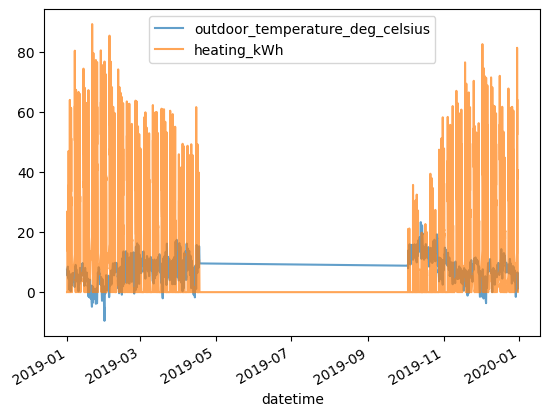

In [ ]:
df.plot(y=["outdoor_temperature_deg_celsius", "heating_kWh"], alpha=0.7)

#### Split train/test and divide in windows

In [ ]:
validation_start = datetime.datetime.fromisoformat("2019-10-01")
datamodule = TimeSeriesDataModule(
    df,
    batch_size=4,
    batch_first=True,
    columns_inputs=["outdoor_temperature_deg_celsius", "occupation"],
    columns_targets=["heating_kWh"],
    forecast_size=168,
    stride_size=24,
    validation_start=validation_start,
    train_end=validation_start,
)
datamodule.setup("fit")

#### Load the Transformer model for time series

In [ ]:
# Load transformer mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transformer = Transformer(
    d_input=2, d_model=4, d_output=1, q=4, v=4, h=4, N=1, chunk_mode=None
).to(device)
optimizer = torch.optim.Adam(transformer.parameters())
loss_function = torch.nn.MSELoss()

You can find documentation on the Transformer class here ``https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html``

#### Train

In [ ]:
EPOCHS = 10
hist_loss = np.zeros(EPOCHS)
dataloader_train = datamodule.train_dataloader()
for idx_epoch in range(EPOCHS):
    running_loss = 0
    with tqdm(total=len(dataloader_train.dataset), desc=f"[Epoch {idx_epoch+1:3d}/{EPOCHS}]") as pbar:
        for idx_batch, (x, y) in enumerate(dataloader_train):
            optimizer.zero_grad()
            # Propagate input
            netout = transformer(x.to(device))
            # Comupte loss
            loss = torch.nn.functional.mse_loss(y.to(device)/10+0.3, netout)
            # Backpropage loss
            loss.backward()
            # Update weights
            optimizer.step()
            # Log current loss
            running_loss += loss.item()
            pbar.set_postfix({'loss': running_loss/(idx_batch+1)})
            pbar.update(x.shape[0])
        train_loss = running_loss/len(dataloader_train)
        hist_loss[idx_epoch] = train_loss

[Epoch  10/10]: 100%|██████████| 101/101 [00:00<00:00, 186.70it/s, loss=0.002]


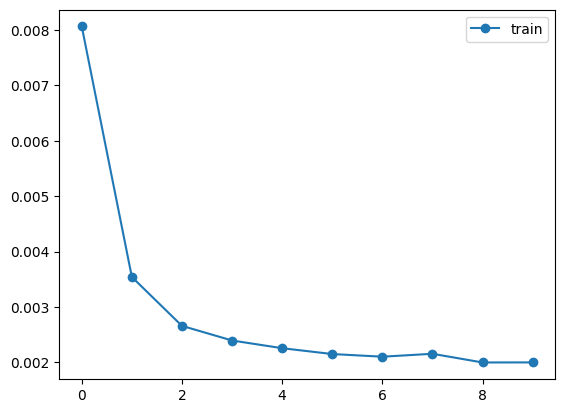

In [ ]:
plt.plot(hist_loss, 'o-', label='train')
plt.legend()

#### Visualize on a validation sample

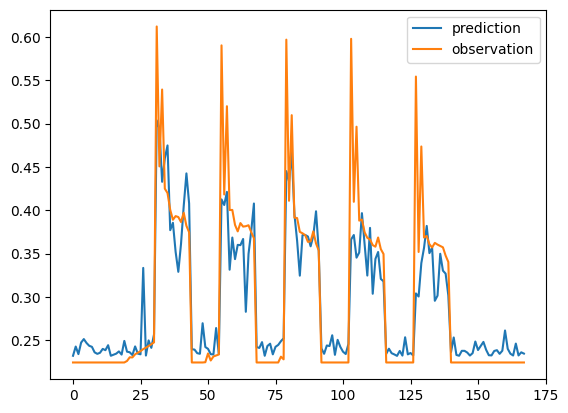

In [ ]:
for x, y in datamodule.train_dataloader():
    break
with torch.no_grad():
    netout = transformer(x.to(device)).cpu()
idx_batch = 0
plt.plot(netout[idx_batch, :, 0].numpy(), label="prediction")
plt.plot(y[idx_batch, :, 0].numpy()/10+0.3, label="observation")
plt.legend();

#### Display an attention map

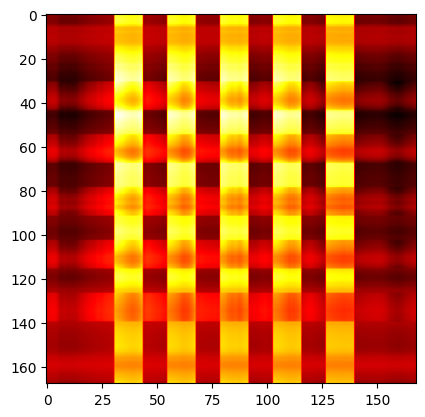

In [ ]:
plt.imshow(transformer.layers_encoding[0].attention_map[0].cpu(), cmap="hot")